# Analysis of CMIP6, ERA5, and CloudSat

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')
from imports import (xr, glob, ccrs, cy, np, pd, #stats, 
plt, cm, fct)




In [2]:
# reload imports
%load_ext autoreload
%autoreload 2

In [3]:
variable_id = [
               # ['prsn', 'sf'],
               # ['clivi', 'tciw']
               ['lwp', 'tclw'],
               # ['tas', '2t']
               ]

In [70]:
cmip_file = '/scratch/franzihe/output/CMIP6_hist/1deg/*_Amon_1deg_198501_201412.nc'
cfiles = glob(cmip_file)

era_file  = '/scratch/franzihe/output/ERA5/monthly_means/1deg/*_Amon_1deg_198501_201412.nc'
efiles = glob(era_file)

In [71]:
# Read in datasets 
cmip = xr.open_mfdataset(cfiles)
era = xr.open_mfdataset(efiles)

In [72]:
## Snowfall
# kg m-2 s-1 to mm/day *86400
cmip['prsn'] = cmip['prsn']*86400
cmip['prsn'].attrs = {'units' : 'mm day-1', 'long_name' : 'Snowfall', 'comment': 'At surface; includes precipitation of all forms of water in the solid phase',}

# m of water equivalent can be converted to kgm^2/day or mm/day by multiplying by 1000.
era['sf'] = era['sf']*1000
era['sf'].attrs = {'units' : 'mm day-1', 'long_name' : 'Snowfall',}

## IWP and LWP
# convert from kg m-2 to g m-2
cmip['clivi'] = cmip['clivi']*1000
cmip['clivi'].attrs = {'units': 'g m-2', 'long_name': 'Ice Water Path', 'comment': 'mass of ice water in the column divided by the area of the column (not just the area of the cloudy portion of the column). Includes precipitating frozen hydrometeors ONLY if the precipitating hydrometeor affects the calculation of radiative transfer in model.'}

cmip['lwp'] = cmip['lwp']*1000
cmip['lwp'].attrs = {'units': 'g m-2', 'long_name': 'Liquid Water Path','comment': 'The total mass of liquid water in cloud per unit area.'}

era['tciw'] = era['tciw']*1000
era['tciw'].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud ice water'}

era['tclw'] = era['tclw']*1000
era['tclw'].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud liquid water'}

In [73]:
def plt_diff_seasonal(true_var, estimated_var, cbar_label, vmin = None, vmax = None, levels = None, title=None):

    fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title, fontsize=16, fontweight="bold")

    axs = axsm.flatten()
    for ax, i in zip(axs, true_var.season):
        im = (true_var - estimated_var).sel(season = i).plot.contourf(ax = ax, 
                                                                      transform = ccrs.PlateCarree(),
                                                                      cmap = cm.bam,
                                                                      robust = True,
                                                                      add_colorbar = False,
                                                                      extend = 'both',
                                                                      vmin = vmin, vmax = vmax,
                                                                      levels = levels)
        # Plot cosmetics
        ax.coastlines()
        gl = ax.gridlines()
        ax.add_feature(cy.feature.BORDERS)
        gl.top_labels = False

    # colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
    # set cbar label
    cb.set_label(label=cbar_label, weight='bold') 

    plt.tight_layout()
    fig.subplots_adjust(top=1)

    return(axs)



In [75]:
cmip_seasonal_mean = cmip.groupby('time.season').mean(('time', 'model'), keep_attrs=True, skipna = True)
era_seasonal_mean  = era.groupby('time.season').mean('time', keep_attrs=True, skipna = True)

In [79]:
if variable_id[0][0] == 'prsn':
    cbar_label = 'Snowfall (mm$\,$day$^{-1}$)'
    vmin = -.6
    vmax=.6
    levels = 30

if  variable_id[0][0] == 'clivi':
    cbar_label = 'Ice Water Path (g$\,$m$^{-2}$)'
    vmin = -30
    vmax= 30
    levels = 60
if  variable_id[0][0] == 'lwp':
    cbar_label = 'Liquid Water Path (g$\,$m$^{-2}$)'
    vmin = -30
    vmax= 30
    levels = 60
if variable_id[0][0] == 'tas':
    cbar_label = '2-m temperature (K)'
    vmin = -30
    vmax= 30
    levels = 60

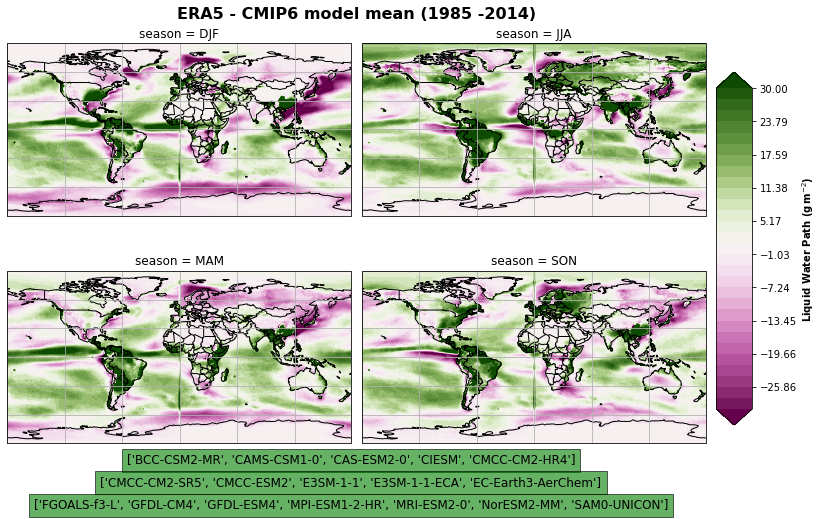

In [80]:
axs = plt_diff_seasonal(era_seasonal_mean[variable_id[0][1]], 
                        cmip_seasonal_mean[variable_id[0][0]], 
                        cbar_label, 
                        vmin = vmin, vmax=vmax, levels = 30, title='ERA5 - CMIP6 model mean (1985 -2014)')
# add model names
axs[2].text(1,-0.12, list(cmip.model.values)[0:5], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5});
if len(list(cmip.model.values)) > 4:
        axs[2].text(1,-0.25, list(cmip.model.values)[5:10], size=12, ha="center", 
                transform=axs[2].transAxes, bbox ={'facecolor':'green',
                        'alpha':0.6,
                        'pad':5});
if len(list(cmip.model.values)) > 10:
        axs[2].text(1,-0.38, list(cmip.model.values)[10:-1], size=12, ha="center", 
                transform=axs[2].transAxes, bbox ={'facecolor':'green',
                        'alpha':0.6,
                        'pad':5});

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6_ERA5_CloudSat/'
figname = '{}_season_1deg_1985_2014.png'.format(variable_id[0][0], )
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

Plot the seasonal mean zonally

In [ ]:
prsn_zonal_season = cmip.groupby('time.season').mean('time', keep_attrs=True, skipna = True).mean('lon', keep_attrs=True, skipna = True)

In [ ]:
prsn_zonal_season_model = cmip.groupby('time.season').mean('time', keep_attrs=True, skipna = True).mean(('model', 'lon'), keep_attrs=True, skipna = True)
prsn_zonal_std_season_model = cmip.groupby('time.season').mean('time', keep_attrs=True, skipna = True).mean(('model', ), keep_attrs=True, skipna = True).std('lon', keep_attrs=True, skipna = True)

In [ ]:
sf_zonal_season = era.groupby('time.season').mean('time', keep_attrs=True, skipna=True).mean('lon', keep_attrs=True, skipna = True)
sf_zonal_std_season = era.groupby('time.season').std('time', keep_attrs=True, skipna=True).std('lon', keep_attrs=True, skipna = True)

In [ ]:
# plot zonal mean for each CMIP6 model
fig, axsm = plt.subplots(2,2, figsize=[10,7], sharex=True, sharey=True,
                         )

fig.suptitle('High resolution (1985 - 2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, prsn_zonal_season.season):
    
    for k, c in zip(cmip.model.values, cm.romaO(range(0, 256, int(256/len(cmip.model.values))))):
        if variable_id[0][0] == 'prsn':
            (prsn_zonal_season[variable_id[0][0]]*86400).sel(season=i, model=k).plot(ax=ax, label = k, color=c, )
        if variable_id[0][0] == 'clivi' or variable_id[0][0] == 'lwp':
            (prsn_zonal_season[variable_id[0][0]]*1000).sel(season=i, model=k).plot(ax=ax, label = k, color=c, )
    
    
    if variable_id[0][0] == 'prsn':
        ax.set_ylabel('Snowfall (mm$\,$day$^{-1}$)', fontweight="bold")
    if variable_id[0][0] == 'clivi':
        ax.set_ylabel('Ice Water Path (g$\,$m$^{-2}$)', fontweight="bold")
    if variable_id[0][0] == 'lwp':
        ax.set_ylabel('Liquid Water Path (g$\,$m$^{-2}$)', fontweight="bold")

    ax.grid()
    ax.set_title('season: {}'.format(i.values))
if variable_id[0][0] == 'prsn':
    axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.5), title='Snowfall (mm$\,$day$^{-1}$)', fontsize='small', fancybox=True, )
if variable_id[0][0] == 'clivi':
    axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.5), title='Ice Water Path (g$\,$m$^{-2}$)', fontsize='small', fancybox=True, )
if variable_id[0][0] == 'lwp':
    axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.5), title='Liquid Water Path (g$\,$m$^{-2}$)', fontsize='small', fancybox=True, )
# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_zonal_mean_1deg_1985_2014.png'.format(variable_id[0][0], )
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [ ]:
# plot zonal mean for each CMIP6 model
fig, axsm = plt.subplots(2,2, figsize=[10,7], sharex=True, sharey=True,
                         )

fig.suptitle('High resolution (1985 - 2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, prsn_zonal_season.season):
    
    
    for k, c in zip(cmip.model.values, cm.romaO(range(0, 256, int(256/len(cmip.model.values))))):
        if variable_id[0][0] == 'prsn':
            (prsn_zonal_season[variable_id[0][0]]*86400).sel(season=i, model=k).plot(ax=ax, label = k, color=c, )

        if variable_id[0][0] == 'clivi' or variable_id[0][0] == 'lwp':   
            (prsn_zonal_season[variable_id[0][0]]*1000).sel(season=i, model=k).plot(ax=ax, label = k, color=c, )
            

    (sf_zonal_season[variable_id[0][1]]*1000).sel(season=i,).plot(ax=ax, label = 'ERA5', color='k')   
    ax.fill_between(sf_zonal_std_season.lat, 
                    (sf_zonal_season[variable_id[0][1]]*1000 - sf_zonal_std_season[variable_id[0][1]]*1000).sel(season=i),
                    (sf_zonal_season[variable_id[0][1]]*1000 + sf_zonal_std_season[variable_id[0][1]]*1000).sel(season=i),
                    alpha=0.3, facecolor='k')

    
  
    if variable_id[0][0] == 'prsn':
        (prsn_zonal_season_model[variable_id[0][0]]*86400).sel(season=i, ).plot(ax=ax, label = 'CMIP6 mean', color='k', linestyle='--' )
        ax.set_ylabel('Snowfall (mm$\,$day$^{-1}$)', fontweight="bold")
    if variable_id[0][0] == 'clivi':
        (prsn_zonal_season_model[variable_id[0][0]]*1000).sel(season=i, ).plot(ax=ax, label = 'CMIP6 mean', color='k', linestyle='--' )
        ax.set_ylabel('Ice Water Path (g$\,$m$^{-2}$)', fontweight="bold")
    if variable_id[0][0] == 'lwp':
        (prsn_zonal_season_model[variable_id[0][0]]*1000).sel(season=i, ).plot(ax=ax, label = 'CMIP6 mean', color='k', linestyle='--' )
        ax.set_ylabel('Liquid Water Path (g$\,$m$^{-2}$)', fontweight="bold")
        

    ax.grid()
    ax.set_title('season: {}'.format(i.values))
if variable_id[0][0] == 'prsn':
    axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.5), title='Snowfall (mm$\,$day$^{-1}$)', fontsize='small', fancybox=True, )
if variable_id[0][0] == 'clivi':
    axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.5), title='Ice Water Path (g$\,$m$^{-2}$)', fontsize='small', fancybox=True, )
if variable_id[0][0] == 'lwp':
    axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.5), title='Liquid Water Path (g$\,$m$^{-2}$)', fontsize='small', fancybox=True, )


# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6_ERA5_CloudSat/'
figname = '{}_season_zonal_mean_1deg_1985_2014.png'.format(variable_id[0][0], )
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [ ]:
prsn_global_mean = cmip.mean(('time', 'lat', 'lon'), keep_attrs=True, skipna = True)

In [ ]:
sf_global_mean = era.mean(('time', 'lat', 'lon'), keep_attrs=True, skipna = True)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[10,7], sharex=True, sharey=True,
                         )
fig.suptitle('Global mean (1985 - 2014)', fontsize=16, fontweight="bold")
ax.grid()

for k, c, pos in zip(cmip.model.values, cm.romaO(range(0, 256, int(256/len(cmip.model.values)))), range(len(cmip.model.values))):
    if variable_id[0][0] == 'prsn':
        ax.bar(pos, (prsn_global_mean[variable_id[0][0]]*86400).sel(model=k).values, color =c, width = 0.5)
    if variable_id[0][0] == 'clivi' or variable_id[0][0] == 'lwp':
        ax.bar(pos, (prsn_global_mean[variable_id[0][0]]*1000).sel(model=k).values, color =c, width = 0.5)

ax.bar(len(cmip.model.values), (sf_global_mean[variable_id[0][1]]*1000).values, color ='k', width=0.5)
ax.set_xticks(range(len(np.append((cmip.model.values), 'ERA5').tolist()))) 
ax.set_xticklabels(np.append((cmip.model.values), 'ERA5').tolist(), fontsize=12, rotation = 90, )

if variable_id[0][0] == 'prsn':
    ax.set_ylabel('Snowfall (mm$\,$day$^{-1}$)', fontweight="bold")
if variable_id[0][0] == 'clivi':
    ax.set_ylabel('Ice Water Path (g$\,$m$^{-2}$)', fontweight="bold")
if variable_id[0][0] == 'lwp':
    ax.set_ylabel('Liquid Water Path (g$\,$m$^{-2}$)', fontweight="bold")

plt.tight_layout()

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6_ERA5_CloudSat/'
figname = '{}_global_mean_1deg_1985_2014.png'.format(variable_id[0][0], )
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

Plot scatter zonal mean

In [ ]:
cmip = xr.open_mfdataset(cfiles)
era = xr.open_mfdataset(efiles)

In [ ]:
cmip_zonal_season = cmip.groupby('time.season').mean('time', keep_attrs=True, skipna = True).mean('lon', keep_attrs=True, skipna = True)

In [ ]:
era_zonal_season = era.groupby('time.season').mean('time', keep_attrs=True, skipna = True).mean('lon', keep_attrs=True, skipna = True)

In [ ]:
# plot zonal mean for each CMIP6 model
fig, axsm = plt.subplots(2,2, figsize=[10,7], sharex=True, sharey=True,
                         )

fig.suptitle('IWP vs. Snowfall (zonal, 1985 - 2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, prsn_zonal_season.season):
    ax.grid()
    # for k, c in zip(cmip.model.values, cm.romaO(range(0, 256, int(256/len(cmip.model.values))))):
    #     ax.scatter((cmip_zonal_season['clivi']*1000).sel(season=i, model=k), (cmip_zonal_season['prsn']*86400).sel(season=i, model=k), label=k, color =c )
    ax.scatter((cmip_zonal_season['clivi']*1000).mean('model').sel(season=i), (cmip_zonal_season['prsn']*86400).mean('model').sel(season=i), label ='CMIP6 mean', color = 'grey')
    ax.scatter((era_zonal_season['tciw']*1000).sel(season=i), (era_zonal_season['sf']*1000).sel(season=i), label='ERA5', color = 'k')
    
    ax.set_ylabel('Snowfall (mm$\,$day$^{-1}$)', fontweight="bold")
    ax.set_xlabel('Ice Water Path (g$\,$m$^{-2}$)', fontweight="bold")

axs[1].legend(loc='center left', bbox_to_anchor=(1, -0.), fontsize='small', fancybox=True, )

plt.tight_layout()

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6_ERA5_CloudSat/'
figname = 'prsn_clivi_zonal_1deg_1985_2014.png'
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

Calculate significance of ERA5-CMIP6 difference, with the help of two-sample t-test.

### Hypothesis
When performing t-tests you typically have the following two hypotheses:
- Null hypotheses: Two group means are equal
- Alternative hypotheses: Two group means are different (two-tailed)

### Assumptions
- Assumption 1: Are the two samples independent?
    - yes
- Assumption 2: Are the data from each of the 2 groups following a normal distribution?
- Assumption 3: Do the two samples have the same variances (Homogeneity of Variance)?

In [ ]:
cmip_file = '/scratch/franzihe/output/CMIP6_hist/1deg/{}_Amon_1deg_198501_201412.nc'.format(variable_id[0][0])
era_file = '/scratch/franzihe/output/ERA5/monthly_means/1deg/{}_Amon_1deg_198501_201412.nc'.format(variable_id[0][1])

cmip = xr.open_dataset(cmip_file)
cmip = cmip.mean('model', keep_attrs = True)
era = xr.open_dataset(era_file)

In [ ]:
['clivi', 'tciw']


In [ ]:
cmip_file = '/scratch/franzihe/output/CMIP6_hist/1deg/*_Amon_1deg_198501_201412.nc'
ff = glob(cmip_file)
ff

In [ ]:
_ds = xr.open_dataset(ff[0]).mean('model', keep_attrs = True)

In [ ]:
_ds_cmip = dict()
for i in range(len(ff)):
    _ds_cmip[ff[i].split('/')[-1].split('_')[0]] = xr.open_dataset(ff[i], decode_times=True).mean('model', keep_attrs = True)


In [ ]:
list(_ds_cmip.values())

In [ ]:
list(_ds_cmip.keys())

In [ ]:
variable_id = [
               ['prsn', 'sf'],
               # ['clivi', 'tciw']
            #    ['lwp', 'tclw'],
               # ['tas', '2t']
               ]

In [ ]:
xr.open_dataset(ff[1]).mean('model', keep_attrs = True)

In [ ]:
xr.concat([xr.open_dataset(ff[0]).mean('model', keep_attrs = True), xr.open_dataset(ff[1]).mean('model', keep_attrs = True)])

In [ ]:
if variable_id[0][0] ==  'prsn':
    # kg m-2 s-1 to mm/day *86400
    prsn = cmip[variable_id[0][0]]*86400

    # m of water equivalent can be converted to kgm^2/day or mm/day by multiplying by 1000.
    sf = era[variable_id[0][1]]*1000

If our variable follows a normal distribution, the quantiles of our variable must be perfectly in line with the “theoretical” normal quantiles: a straight line on the QQ Plot tells us we have a normal distribution.

In [ ]:
fig = plt.figure(figsize=(10,7))

ax1 = plt.subplot(121)
stats.probplot(prsn.values.flatten(), dist="norm", plot= plt);

ax2 = plt.subplot(122)
stats.probplot(sf.values.flatten(), dist="norm", plot= plt);

fig.suptitle(era[variable_id[0][1]].attrs['long_name']);
plt.tight_layout()
fig.subplots_adjust(top=1)


In [ ]:
sf_stat = sf.groupby('time.season').mean('time').sel(season = 'DJF').to_pandas()
prsn_stat = prsn.groupby('time.season').mean('time').sel(season = 'DJF').to_pandas()

In [ ]:
sf_stat.describe()

In [ ]:
prsn_stat.describe()

In [ ]:
sf_stat

In [ ]:
from scipy import stats

stats.shapiro(sf_stat[0.])

In [ ]:
stats.shapiro(prsn_stat[0.])

In [ ]:
stats.levene(sf_stat[0], prsn_stat[0])

In [ ]:
data = [['ERA5', len(sf), sf.mean().round(3).values, sf.std().round(3).values], 
        ['CMIP6', len(prsn), prsn.mean().round(3).values, prsn.std().round(3).values]]
pd.DataFrame(data, columns=["Group", "Sample Size (n)", "Average (X-bar)",	"Standard deviation (s)"])

Without doing any testing, we can see that the averages for ERA5 and CMIP6 in our samples are almost the same for snowfall. We start by calculating our test statistic. This difference in our samples estimates the difference between the population means for the two groups. This calculation begins with finding the difference between the two averages:

$M = \overline X - \overline Y$

In [ ]:
diff_mean = sf.mean() - prsn.mean()
diff_mean.round(3)

Next, we calculate the pooled standard deviation. This builds a combined estimate of the overall standard deviation. The estimate adjusts for different group sizes. First, we calculate the pooled variance:

$s_p^2 = \displaystyle\frac{(n_1 - 1)* s_1^2 + (n_2 - 1)* s_2^2}{n_1 + n_2 -2} $

In [ ]:
var = ((len(sf) - 1)*sf.std()**2 + (len(prsn) -1)*prsn.std()**2)/(len(sf) + len(prsn) -2)
var

Next, we take the square root of the pooled variance to get the pooled standard deviation.

$s_p = \sqrt{s_p^2}$

In [ ]:
std = np.sqrt(var)
std

We now have all the pieces for our test statistic. We have the difference of the averages, the pooled standard deviation and the sample sizes.  We calculate our test statistic as follows:

$t = \displaystyle\frac{\text{difference of group averages}}{\text{standard error of difference}}$

$t = \displaystyle\frac{M}{s_p * \sqrt{\frac{1}{m} + \frac{1}{n}}}$

In [ ]:
t = diff_mean/(std * np.sqrt(1/len(sf) + 1/len(prsn)))
t

To evaluate the difference between the means in order to make a decision about our datasets, we compare the test statistic to a theoretical value from the t-distribution. This activity involves four steps:
1. We decide on the risk we are willing to take for declaring a significant difference. For the data, we decide that we are willing to take a 95% risk of saying that the unknown population means for ERA5 and CMIP6 are not equal when they really are. In statistics-speak, the significance level, denoted by $\alpha$, is set to 0.95. It is a good practice to make this decision before collecting the data and before calculating test statistics.
2. We calculate a test statistic. Our test statistic is 0.594 for snowfall.
3. We find the theoretical value from the t-distribution based on our null hypothesis which states that the means for ERA5 and CMIP6 are equal. Most statistics books have look-up tables for the t-distribution. You can also find tables online. The most likely situation is that you will use software and will not use printed tables.
To find this value, we need the significance level ($\alpha$ = 0.95) and the degrees of freedom. The degrees of freedom (df) are based on the sample sizes of the two groups. For the snowfall data, this is:
$df = n_1 + n_2 - 2 = 718$ 
The t value with $\alpha$ = 0.95 and 718 degrees of freedom is .

4. We compare the value of our statistic (0.594) to the t value. Since t > T, we reject the null hypothesis that the snowfall for ERA5 and CMIP6 are equal, and conclude that we have evidence snowfall in the population is different between ERA5 and CMIP6.


#### Statistical details

Let’s look at the snowfall data and the two-sample t-test using statistical terms.

- Our null hypothesis is that the underlying population means are the same. The null hypothesis is written as:
Ho: $\mu_1=\mu_2$

- The alternative hypothesis is that the means are not equal. This is written as:
Ho: $\mu_1 \neq \mu_2$

- We calculate the average for each group, and then calculate the difference between the two averages. This is written as:
$\overline x_1 - \overline x_2$

- We calculate the pooled standard deviation. This assumes that the underlying population variances are equal. The pooled variance formula is written as:
$s_p^2 = \displaystyle\frac{(n_1 - 1)* s_1^2 + (n_2 - 1)* s_2^2}{n_1 + n_2 -2} $
The formula shows the sample size for the first group as $n_1$ and the second group as $n_2$. The standard deviations for the two groups are $s_1$ and $s_2$. This estimate allows the two groups to have different numbers of observations. The pooled standard deviation is the square root of the variance and is written as $s_p$.

What if your sample sizes for the two groups are the same? In this situation, the pooled estimate of variance is simply the average of the variances for the two groups:

$s_p^2 = \displaystyle\frac{s_1^2 +  s_2^2}{2} $

- The test statistic is calculated as:
$t = \displaystyle\frac{\overline x_1 - \overline x_2}{s_p * \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$

The numerator of the test statistic is the difference between the two group averages. It estimates the difference between the two unknown population means. The denominator is an estimate of the standard error of the difference between the two unknown population means. 

- We then compare the test statistic to a t value with our chosen alpha value and the degrees of freedom for our data. Using the snowfall data as an example, we set $\alpha$ = 0.95. The degrees of freedom (df) are based on the group sizes and are calculated as:
$df = n_1 + n_2 - 2 $ 

The formula shows the sample size for the first group as $n_1$ and the second group as $n_2$. Statisticians write the t value with $\alpha$ = 0.95 and 718 degrees of freedom as:
$t_{0.95,718}$

There are two possible results from our comparison:
- The test statistic is lower than the t value. You fail to reject the hypothesis of equal means. You conclude that the data support the assumption that the ERA5 and CMIP6 have the same average snowfall.
- The test statistic is higher than the t value. You reject the hypothesis of equal means. You do not conclude that ERA5 and CMIP6 have the same average snowfall

[Taken from the statisitcs knowledge portal](https://www.jmp.com/en_ch/statistics-knowledge-portal/t-test/two-sample-t-test.html)


In [ ]:
from scipy import stats

# snowfall (ERA5)
_sf = era.sf.groupby('time.season').mean('time')*1000

# snowfall (CMIP6)
_prsn = cmip.prsn.groupby('time.season').mean('time')*86400

_stat = stats.ttest_ind(_sf, _prsn)

Before the t-test can be conducted, one needs to test the assumptions. First to test for the homogeneity of variances. To do this, I will use Levene’s test for homogeneity of variance. The method to conduct this test is stats.levene().

In [ ]:
stats.levene(_sf.values.flatten(), _prsn.values.flatten())

Next to test the assumption of normality. This can be done visually with a histogram and/or as a q-q plot, and by using the Shapiro-Wilk test which is the stats.shaprio() method. First, I will check them visually.

In [ ]:
_sf.plot();

In [ ]:
_prsn.plot();

In [ ]:
stats.probplot(_sf.values.flatten(), dist="norm", plot= plt)

In [ ]:
stats.probplot(_prsn.values.flatten(), dist="norm", plot= plt)

To be sure, we can test it statistically using the Shapiro-Wilk test for normality which is the stats.shaprio() method. Unfortunately the output is not labeled. The first value is the W test statistic and the second value is the p-value.

In [ ]:
print(stats.shapiro(_sf), stats.shapiro(_prsn)) 

Neither of the tests for normality we significant meaning neither of the variables violates the assumption of normality. We can continue as planned. To conduct the Independent t-test, one needs to use the stats.ttest_ind() method.

In [ ]:
stats.ttest_ind(_sf, _prsn)

In [ ]:
n = len(diff.coords['season'])
mean_diff = diff.mean('season')
s_std = diff.std('season') * np.sqrt(n /(n-1))
t = mean_diff/ (s_std/np.sqrt(n))

In [ ]:
T = stats.t.ppf(1 - ((1 - .95) / 2), n - 1) 

In [ ]:
sig_map = (t > T) | (t < -T)

In [ ]:
sig_map

In [ ]:
    """
    Source: Modern Mathematical Statistics with Applications by Devore & Berk
    Assumptions:
    - data consists of independently selected pairs (X1,Y1)
    - Di=Xi-Yi are assumed to be normally distributed.
    :param da1:
    :param da2:
    :param avg_dim:
    :param ci:
    :return:
    """
    D = da1 - da2
    n = len(D.coords[avg_dim])
    mean_D = D.mean(avg_dim)
    # sample std:
    # population std= sqrt(sum((xi-mu)^2)/n)
    # sample std =  sqrt(sum((xi-mu)^2)/(n-1))
    # sample std = (population std)*(sqrt(n/(n-1))
    s_std = D.std(avg_dim) * np.sqrt(n / (n - 1))
    t = mean_D / (s_std / np.sqrt(n))
    # for small samples (<50) we use t-statistics
    # n = 9, degree of freedom = 9-1 = 8
    # for 99% confidence interval, alpha = 1% = 0.01 and alpha/2 = 0.005
    T = stats.t.ppf(1 - ((1 - ci) / 2), n - 1)  # 99% CI, t8,0.005
    sig_map = (t > T) | (t < -T)
    return T, sig_map, t

In [ ]:
_stat.statistic

In [ ]:
t

In [ ]:
mask_jja.shape

In [ ]:
fig, axsm = plt.subplots(1,1, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})

axsm.pcolor(cmip.lon.values, cmip.lat.values, _t.values, hatch='xxx', color = 'k', zorder = 100000, alpha=0.0 ,transform = ccrs.PlateCarree())

In [ ]:
_stat.pvalue

In [ ]:
diff.where(diff.quantile(0.95, keep_attrs=True)).plot()#.where(diff >= 0.95).plot()

In [ ]:
def hatch_area(TF,ax, hatches=None, hatch_lw = .5, reverse=False, transform=None):
    mpl.rcParams['hatch.linewidth'] = hatch_lw
    if reverse:
        TF=~TF
    if hatches is None:
        hatches=['....','']
    if set(TF.dims)=={'lat','lev'}:
        x_coord = TF.lat
        y_coord = TF.lev
    elif set(TF.dims)=={'lat','lon'}:
        x_coord = TF.lon
        y_coord = TF.lat
    else:
        x_coord = TF[TF.dims[0]]
        y_coord = TF[TF.dims[1]]

    #ax.contourf( x_coord,y_coord, TF.where(TF), hatches=hatches, transform=transform, alpha=0, extend='both')
    plt_kwgs = dict(hatch=hatches[0], rasterized=True, alpha=0)
    if transform is not None:
        plt_kwgs['transform']=transform
    ax.pcolor( x_coord,y_coord, TF.where(TF), **plt_kwgs)#hatch=hatches[0],rasterized=True, transform=transform, alpha=0)

In [ ]:
# T_star_jja: T_star data on lon/lat grid
# make a mask of lon/lat cells following your significance criteria (in my case data_jja (also on the same lon/lat grid) is below 6)
mask_jja = np.ma.masked_less(data_jja, 6.0)# plotting on a polar plot of your data
cs = plt_var_polar(fig, axs[0], lon2d, lat2d, T_star_jja, ‘T_star JJA’, ‘N’, discrete_cmap(16, cm_crameri.oslo), vmin = 238, vmax = 270, n_cmap = 16)# overlay the hatching of the not significant data
cs2 = axs[0].pcolor(lon2d-2.5, lat2d-2.5, mask_jja, hatch=‘xxx’, color = ‘k’, zorder = 100000, alpha=0.0 ,transform = ccrs.PlateCarree())